In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import scipy.stats as stats
import pickle

sns.set(style="ticks", context='poster', font_scale=0.9)
%matplotlib inline

RANDOM_SEED = 8927

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w 

Last updated: Fri Sep 13 2024

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.27.0

pandas    : 2.2.2
pymc      : 5.9.1
seaborn   : 0.13.2
scipy     : 1.11.3
numpy     : 1.25.2
arviz     : 0.19.0
matplotlib: 3.8.1

Watermark: 2.4.3



# A hierarchical Bayesian model 

To estimate the probability of developing the probability of developing the Eu mouth form in _P. pacificus_, we constructed a hierarchical Bayesian model.  We use the data from the first generation of the control lines of the LTEI to illustrate how the probability of assuming the predatory (Eu) mouth form is inferred from the experimental data.

In [3]:
LTEI_ctrl = pd.read_excel('./raw_data/control_LTEI.xlsx', index_col=0)

In [4]:
LTEI_ctrl.head(3)

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F91,F92,F93,F94,F95,F96,F97,F98,F99,F100
1,3,4,3,3,3,3,5,3,5,4,...,3,2,2,3,5,9,6,2,2,5
2,4,3,3,3,4,4,4,3,5,8,...,3,4,3,3,5,8,6,4,5,5
3,3,1,4,3,5,3,5,2,4,3,...,3,4,2,2,3,6,9,3,2,5


In [5]:
G_samples = np.array(LTEI_ctrl['F1'])

In [6]:
# parameters of hyperprior ω
a=2 
b=2
# The total number of worms observed per plate
n_total=20
n_sets = len(G_samples)
N_samples = np.repeat(n_total, n_sets)
group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))
with pm.Model() as model:
    ω = pm.Beta('ω', a, b)
    κ = pm.Gamma('κ', 3, 1)
    θ = pm.Beta('θ', alpha=ω*(κ-2)+1, beta=(1-ω)*(κ-2)+1, shape=n_sets)
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data)

### The structure of the model:

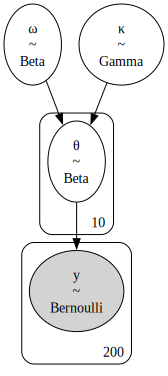

In [7]:
pm.model_to_graphviz(model)

In [8]:
with model:
    trace = pm.sample(tune=1000, draws=10000, target_accept=0.95, random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ω, κ, θ]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 10 seconds.


### Visual inspection to ensure stability of the inference:

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'κ'}>, <Axes: title={'center': 'κ'}>],
       [<Axes: title={'center': 'ω'}>, <Axes: title={'center': 'ω'}>]],
      dtype=object)

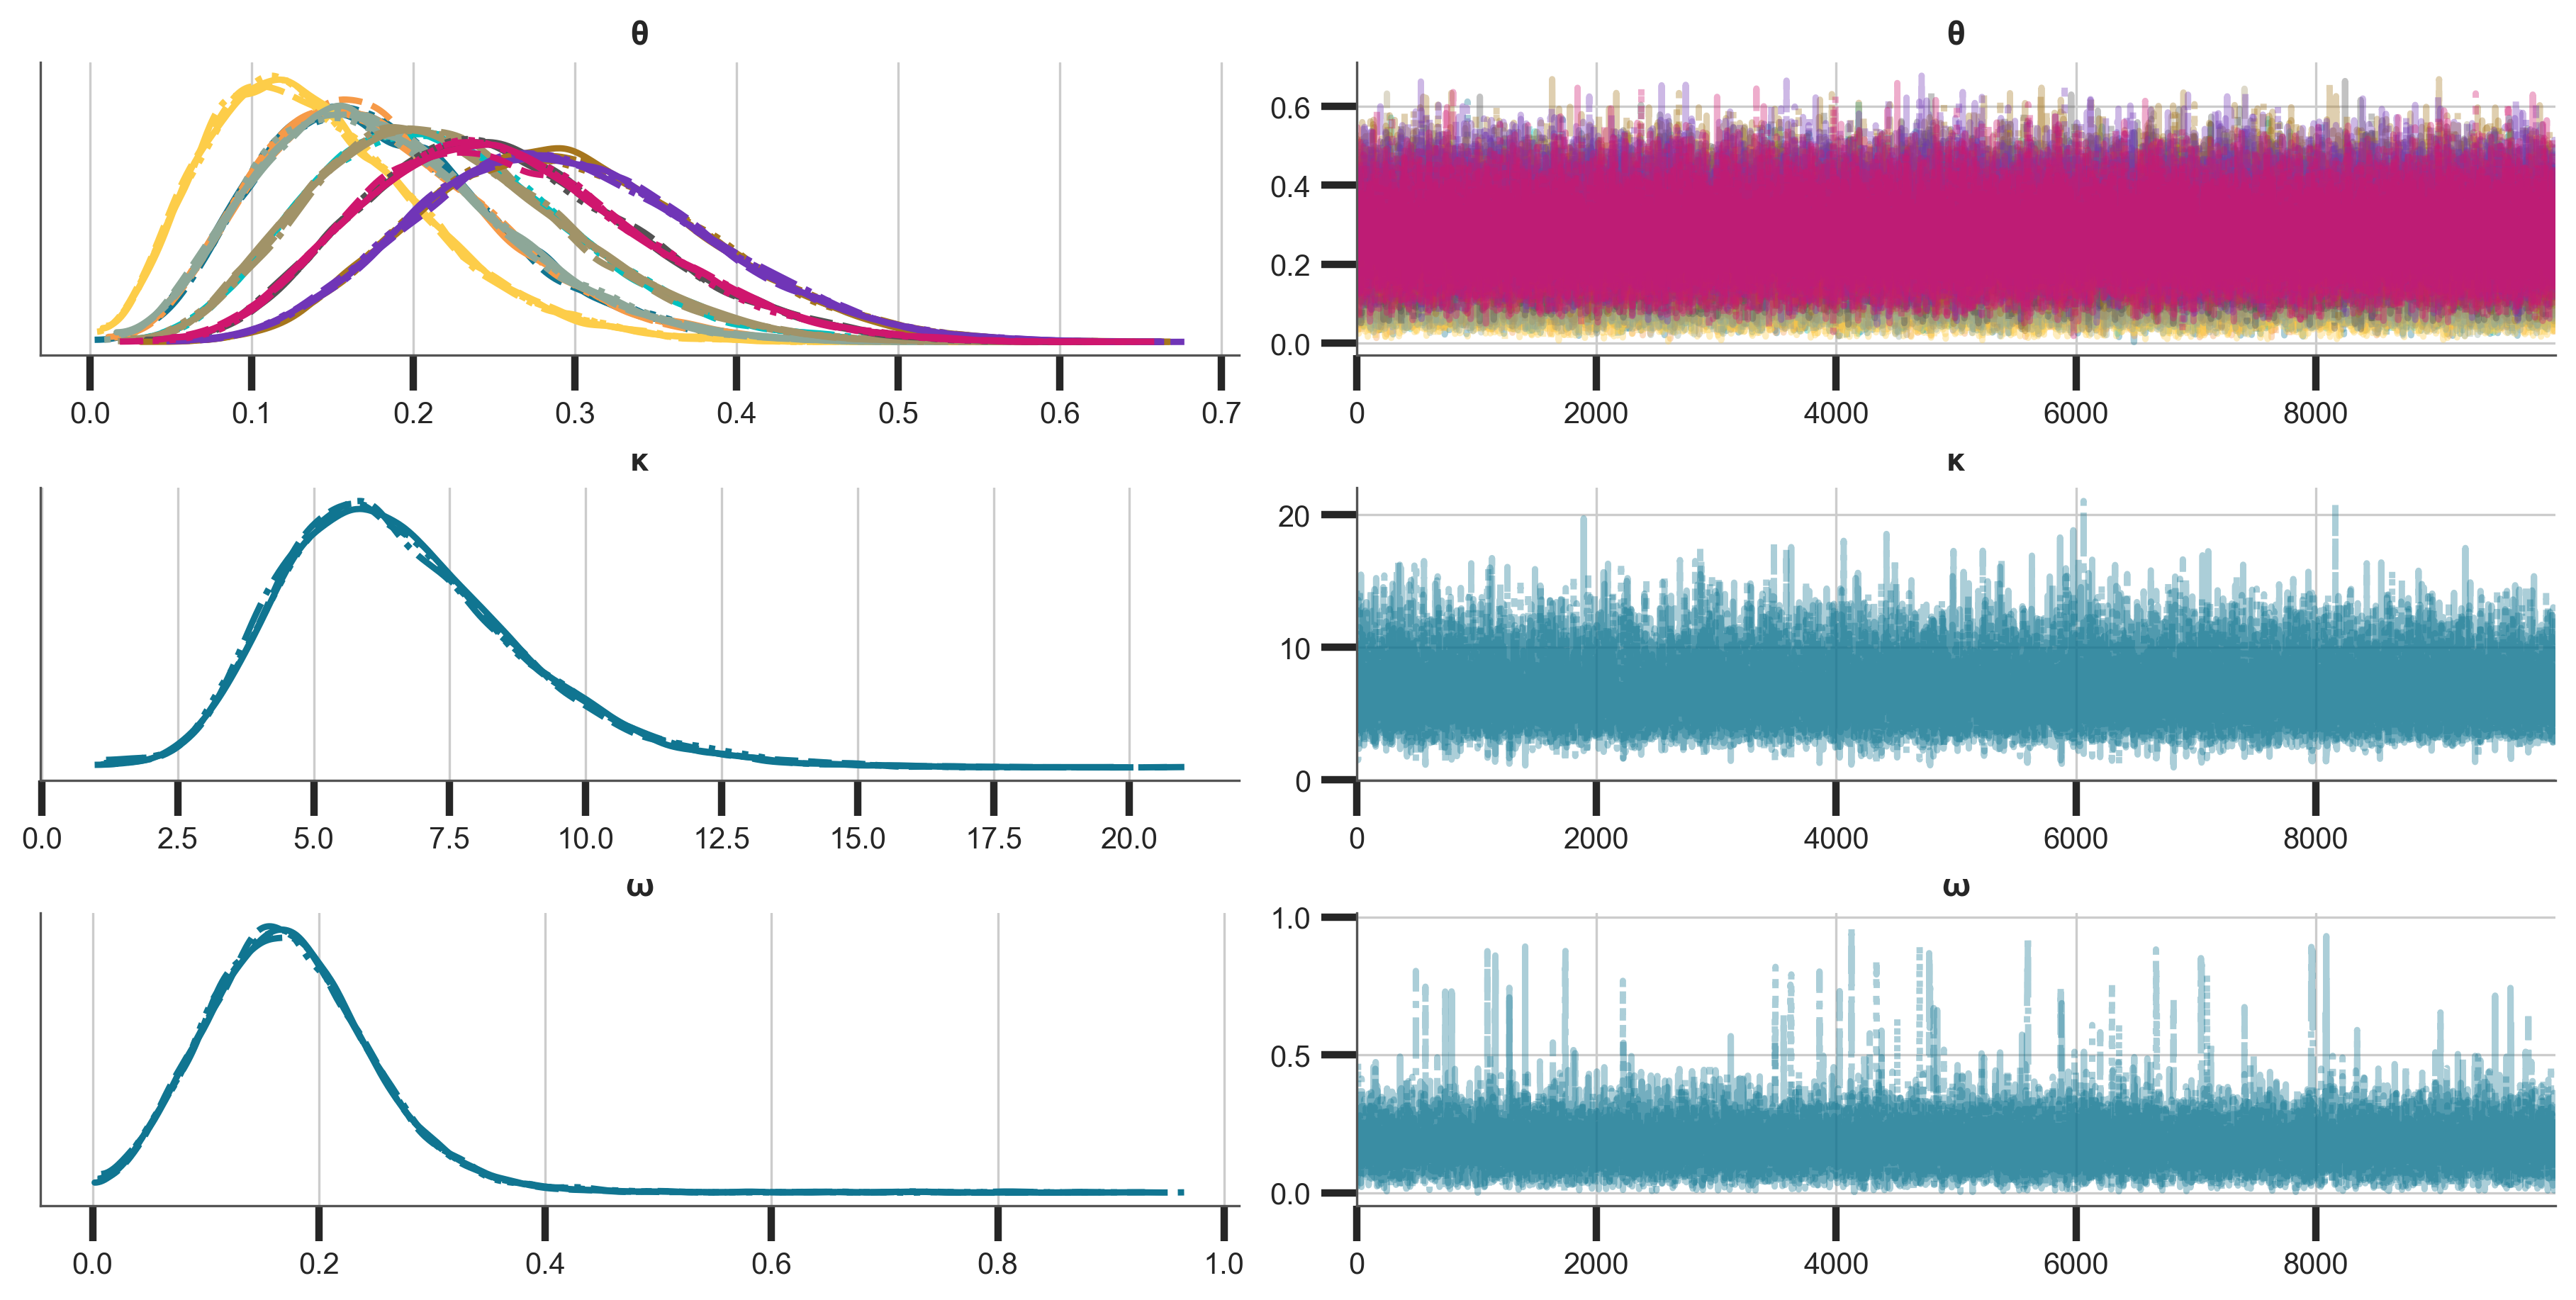

In [9]:
az.style.use("arviz-docgrid")
az.plot_trace(trace, compact=True)

### Text-based output of common posterior statistics:

In [10]:
az.summary(trace, hdi_prob=0.95, round_to=2)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
θ[0],0.18,0.07,0.05,0.33,0.00,0.00,47188.49,25556.56,1.0
θ[1],0.22,0.08,0.08,0.38,0.00,0.00,43391.52,27122.54,1.0
θ[2],0.18,0.07,0.05,0.32,0.00,0.00,42485.62,25988.53,1.0
θ[3],0.14,0.07,0.02,0.27,0.00,0.00,41266.80,22912.49,1.0
θ[4],0.18,0.07,0.05,0.33,0.00,0.00,41973.34,25654.54,1.0
θ[5],0.22,0.08,0.08,0.38,0.00,0.00,46939.96,27838.16,1.0
θ[6],0.26,0.08,0.11,0.43,0.00,0.00,45747.42,28355.63,1.0
θ[7],0.29,0.09,0.13,0.47,0.00,0.00,37110.79,26378.65,1.0
θ[8],0.29,0.09,0.13,0.47,0.00,0.00,48709.60,28943.28,1.0
θ[9],0.26,0.09,0.10,0.42,0.00,0.00,45920.31,26236.05,1.0
